## 911 Calls project
In this project I will analyze some 911 call data from [Kaggle](https://www.kaggle.com/mchirico/montcoalert). The data contains the following fields:

* lat : String variable, Latitude
* lng: String variable, Longitude
* desc: String variable, Description of the Emergency Call
* zip: String variable, Zipcode
* title: String variable, Title
* timeStamp: String variable, YYYY-MM-DD HH:MM:SS
* twp: String variable, Township
* addr: String variable, Address
* e: String variable, Dummy variable (always 1)

The dataset is 911 calls from Pennsylvania during the end of 2015 till August 2016.


In [1]:
from IPython.core.display import HTML

## Table Of Contents:
* [1. Obtain data](#1)
* [2. Data cleaning](#2)
* [3. Data exploration](#3)
* [4. Modeling](#4)

## 1. Obtain the data <a class="anchor" id="1"></a>
I will load the data and import some important libraries.
* The file "us_zipcode.csv" is originally from https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.signal import find_peaks
import matplotlib.dates as mdates
from datetime import datetime
%matplotlib inline
sns.set()

In [2]:
df = pd.read_csv("data/911.csv")
df.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:40:00,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:40:00,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 17:40:00,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 17:40:01,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 17:40:01,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


## Data cleaning <a class="anchor" id="2"></a>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99492 entries, 0 to 99491
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lat        99492 non-null  float64
 1   lng        99492 non-null  float64
 2   desc       99492 non-null  object 
 3   zip        86637 non-null  float64
 4   title      99492 non-null  object 
 5   timeStamp  99492 non-null  object 
 6   twp        99449 non-null  object 
 7   addr       98973 non-null  object 
 8   e          99492 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 6.8+ MB


I will make an extra column for the reason of the call (it will help with grouping the types of the calls)

In [4]:
def StationMiner(x):
    try:
        return (re.sub('[:]', '', x.split('Station')[1].split(';')[0])).strip()
    except:
        return np.nan   
    
df['station']=df['desc'].apply(lambda x: StationMiner(x))
df["reason"] = df.title.apply(lambda x: x.split(":")[0])
df["issue"] = df.title.apply(lambda x: x.split(":")[1].strip())
df["issue"] = df["issue"].replace('-', '', regex=True)

df["timeStamp"] = pd.to_datetime(df.timeStamp)
df["hour"] = df.timeStamp.apply(lambda x: x.hour)
df["month"] = df.timeStamp.apply(lambda x: x.month)
df["day_of_week"] = df.timeStamp.apply(lambda x: x.dayofweek) 

df.drop(columns=['desc','title','addr','e'],inplace=True)

#Just organizing the columns in a reasonable oreder
df = df[['lat','lng', 'zip', 'twp','station', 'reason','issue','timeStamp','hour','month','day_of_week']]
df.info()

99492-86637

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99492 entries, 0 to 99491
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   lat          99492 non-null  float64       
 1   lng          99492 non-null  float64       
 2   zip          86637 non-null  float64       
 3   twp          99449 non-null  object        
 4   station      63797 non-null  object        
 5   reason       99492 non-null  object        
 6   issue        99492 non-null  object        
 7   timeStamp    99492 non-null  datetime64[ns]
 8   hour         99492 non-null  int64         
 9   month        99492 non-null  int64         
 10  day_of_week  99492 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 8.3+ MB


12855

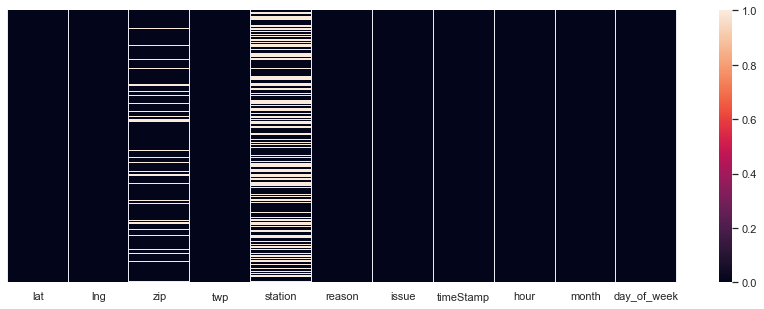

In [5]:
plt.figure(figsize=(15,5))
sns.heatmap(df.isnull(),yticklabels=False)

We have some of zip data that missing, but we have the latitude and longitude of every call - so I
need to mine the data from source like google/yandex and other geocoder resources - but the API is not for free.
After a sort search on the web i find an geocoder provider with 15,000 monthly limit (and our missing data is only 12,855!) - 
http://more.stevemorse.org/latlonbatch2.html?direction=reverse

In [6]:
# Remove all duplicates for lat lng.
LatLng=df[df['zip'].isna()][['lat','lng']].drop_duplicates()
# Convert them to list to be readable by geocoder
LatLng.to_csv('./data//LatLng.csv',index=False)
LL=LatLng.values.tolist()


My web scraping skills are not at this level so i used Monzenda for the intergration of CSV files.

In [7]:
LatLngAddress = pd.read_csv('./data//LatLngAddress.csv')
LLZ = LatLngAddress[['lat','lng','zipcode']]
df['idx'] = df.index
df1 = df[df['zip'].isna()]
df2 = df[~df['zip'].isna()]
df = pd.merge(left=df1,right=LLZ,how='left',on=['lat','lng'])
df['zip'] = df['zipcode']
df.drop(columns=['zipcode'],inplace=True)
df = df.append(df2,sort=False).set_index('idx').sort_index()
df['zip'] = df['zip'].astype('int32')
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 99492 entries, 0 to 99491
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   lat          99492 non-null  float64       
 1   lng          99492 non-null  float64       
 2   zip          99492 non-null  int32         
 3   twp          99449 non-null  object        
 4   station      63797 non-null  object        
 5   reason       99492 non-null  object        
 6   issue        99492 non-null  object        
 7   timeStamp    99492 non-null  datetime64[ns]
 8   hour         99492 non-null  int64         
 9   month        99492 non-null  int64         
 10  day_of_week  99492 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(3), object(4)
memory usage: 8.7+ MB


In [8]:
ReasonByStation = df.groupby("reason")["station"].count()
print(ReasonByStation)
print(len(df) - ReasonByStation.sum())
print(df.station.isnull().sum())

reason
EMS        48877
Fire       14920
Traffic        0
Name: station, dtype: int64
35695
35695


So when the reason of the call was traffic there was not one documentation about the station.
All the missing stations was referred to Traffic.


In [9]:
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df["day_of_week_str"] = df.day_of_week.map(dmap)

## Data exploration <a class="anchor" id="3"></a>

Text(0.5, 1.05, 'Incidents per month/day')

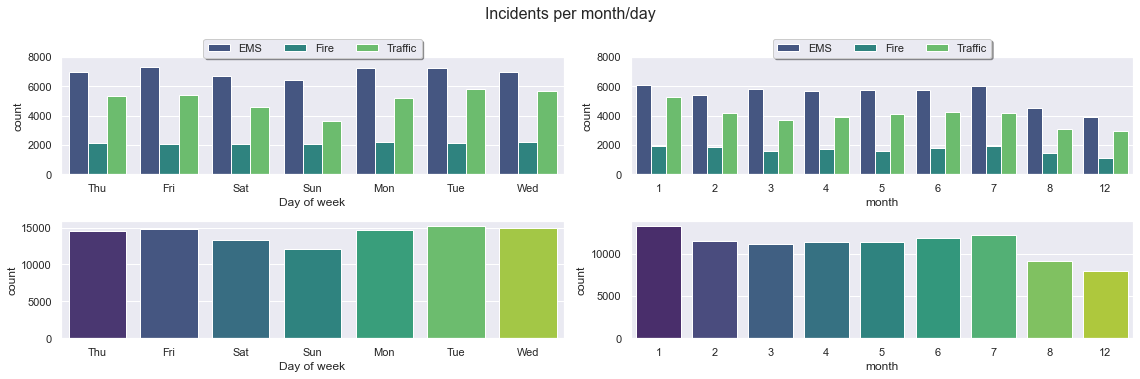

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,5))
ax1 = sns.countplot(data=df, x="day_of_week_str", hue="reason", palette="viridis",ax=axs[0,0])
ax1.set_ylim(0,8000)
ax1.set_xlabel("Day of week")
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=True)

ax2 = sns.countplot(data=df, x="month", hue="reason", palette="viridis",ax=axs[0,1])
ax2.set_ylim(0,8000)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=True)

ax3 = sns.countplot(data=df, x="day_of_week_str", palette="viridis",ax=axs[1,0])
ax3.set_xlabel("Day of week")
ax4 = sns.countplot(data=df, x="month", palette="viridis",ax=axs[1,1])

plt.tight_layout()
fig.suptitle('Incidents per month/day', fontsize=16,y=1.05)


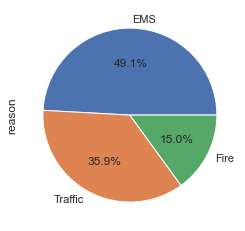

In [11]:
df.reason.value_counts().plot(kind="pie",autopct='%1.1f%%')

Just from curiosity, let's look at the most common and the most rare calls in EMS and Traffic.

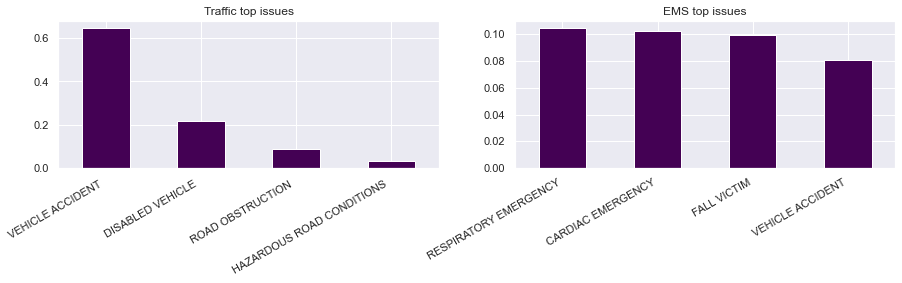

In [12]:
EMS_stats_norm = df.groupby("reason")["issue"].value_counts(normalize=True).loc[["EMS"]]
Traffic_stats_norm = df.groupby("reason")["issue"].value_counts(normalize=True).loc[["Traffic"]]



fig, axs = plt.subplots(1,2,figsize=(15,3))

ax1= Traffic_stats_norm.loc["Traffic"][:4].plot(kind="bar",cmap="viridis",ax=axs[0])
ax2 =EMS_stats_norm.loc["EMS"][:4].plot(kind="bar",cmap="viridis",ax=axs[1])
ax1.set_xlabel("")
ax1.set_title("Traffic top issues")
ax2.set_title("EMS top issues")

ax2.set_xlabel("")
fig.autofmt_xdate()




As we can see, the issues in the EMS section are pretty diversed but mostly about health issues.
In contrast, the Traffice section is more stratight forward when most of the issues are vehicle accidents.

In [13]:
EMS_stats = df.groupby("reason")["issue"].value_counts().loc[["EMS"]]
Traffic_stats = df.groupby("reason")["issue"].value_counts().loc[["Traffic"]]
fire_stats = df.groupby("reason")["issue"].value_counts().loc[["Fire"]]

accidents_1 = EMS_stats.loc["EMS"].loc[["VEHICLE ACCIDENT"]].sum()
accidents_2 = Traffic_stats.loc["Traffic"].loc[["VEHICLE ACCIDENT "]].sum()
accidents_3 = fire_stats.loc["Fire"].loc[["VEHICLE ACCIDENT"]].sum()
proportion = (accidents_1+accidents_2+accidents_3)/len(df)
print(f"{proportion:.3%} of the cases are vehicle accidents")

##find an algorithm to map that kind of stuff (running over all this top 50 groupbys and making some clustering)

28.785% of the cases are vehicle accidents


Let's targeting the time data we have.
First lets check if the datetime objects is not missing any data.

In [14]:
print("Hours", sorted(df.hour.unique()))
print()
print("Months", sorted(df.month.unique()))
print()
print("day_of_week", sorted(df.day_of_week.unique()))

Hours [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

Months [1, 2, 3, 4, 5, 6, 7, 8, 12]

day_of_week [0, 1, 2, 3, 4, 5, 6]


So we missing September-November, let's see how can we fill them.

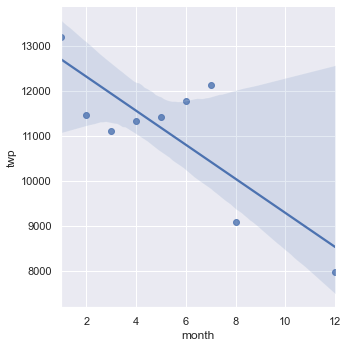

In [15]:
byMonth = df.groupby("month").count()
sns.lmplot(x="month",y="twp", data=byMonth.reset_index())

We can see in the graph above that our missing data is have a big effect on the margin of error from month 8.

#TODO - Clean

Lets take a look at the days with the most calls:

In [16]:
df["date"] = df.timeStamp.apply(lambda x: x.date())
df["date"] = pd.to_datetime(df["date"])

x = df.groupby("date").count()["lat"]
sorted((x.sort_values(ascending=False).index)[:10].tolist())

[Timestamp('2015-12-23 00:00:00'),
 Timestamp('2016-01-12 00:00:00'),
 Timestamp('2016-01-23 00:00:00'),
 Timestamp('2016-01-24 00:00:00'),
 Timestamp('2016-01-25 00:00:00'),
 Timestamp('2016-02-15 00:00:00'),
 Timestamp('2016-02-16 00:00:00'),
 Timestamp('2016-02-24 00:00:00'),
 Timestamp('2016-04-03 00:00:00'),
 Timestamp('2016-07-25 00:00:00')]

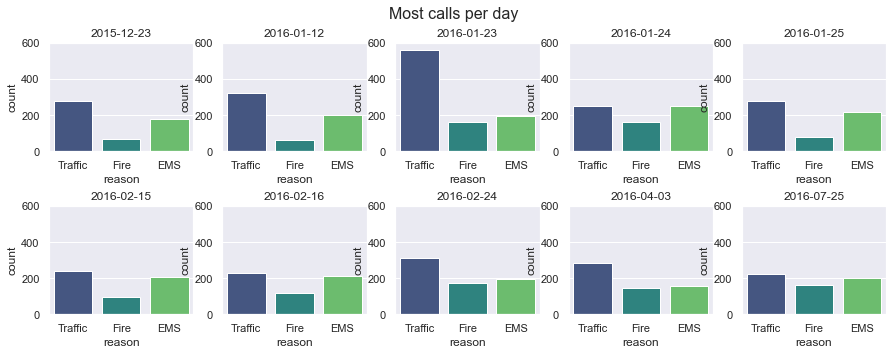

In [17]:
def plotting(dates):
    num_plots = len(dates)
    fig, axes = plt.subplots(2,5,figsize=(15,5))
    fig.subplots_adjust(hspace=0.5)
    
    for i in range(num_plots):
        df1 = df.loc[df["date"] == dates[i]]
        row = i // 5
        col = i % 5
        ax_curr = axes[row, col]
        sns.countplot(x="reason", palette="viridis", data=df1, ax=ax_curr,order=["Traffic","Fire","EMS"])
        ax_curr.set_title(dates[i].date())
        ax_curr.set_ylim(0,600)
        
    plt.suptitle("Most calls per day", fontsize=16)
        
x = df.groupby("date").count()["twp"]
dates1 = sorted((x.sort_values(ascending=False).index)[:10])
plotting(dates1)


##do it prettier.

It seems like the days with the most calls were most between January - February of 2016.

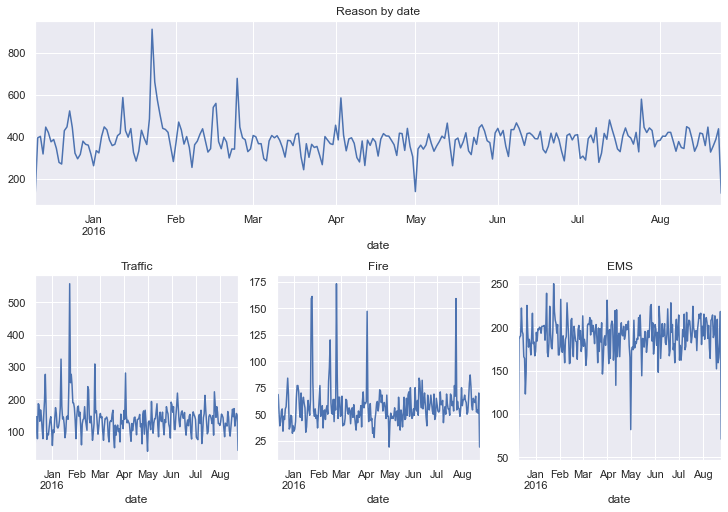

In [18]:
fig3 = plt.figure(constrained_layout=True,figsize=(10,7))
gs = fig3.add_gridspec(2, 3)
f3_ax1 = fig3.add_subplot(gs[0, :])
df.groupby("date").count()["lat"].plot(ax=f3_ax1,title='Reason by date')

f3_ax2 = fig3.add_subplot(gs[1, :1])
df[df["reason"] == "Traffic"].groupby("date")["lat"].count().plot(title="Traffic",ax=f3_ax2)


f3_ax3 = fig3.add_subplot(gs[1, -2])
df[df["reason"] == "Fire"].groupby("date")["lat"].count().plot(title="Fire",ax=f3_ax3)

f3_ax4 = fig3.add_subplot(gs[1:, -1])
df[df["reason"] == "EMS"].groupby("date")["lat"].count().plot(title="EMS",ax=f3_ax4)





[Text(0, 0.5, 'Number of calls'), Text(0.5, 1.0, 'Calls by date')]

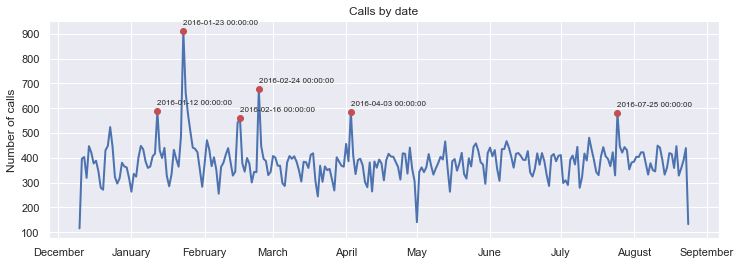

In [19]:

reason_by_date = df.groupby("date").count()["lat"]
peaksCalls, _ = find_peaks(reason_by_date, height=550)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot_date(reason_by_date.index, reason_by_date, 'b-', linewidth = 2)
ax.plot_date(reason_by_date.index[peaksCalls], reason_by_date[peaksCalls], 'ro')
# Add labels to the plot
style = dict(size=6, color='black', bbox=dict(facecolor='gray', alpha=0.5))
#annotation
for date in range(len(reason_by_date.index[peaksCalls])):
    plt.text(reason_by_date.index[peaksCalls][date], reason_by_date[peaksCalls][date]+25, s= f'{reason_by_date.index[peaksCalls][date]}', fontsize=8)

myFmt = mdates.DateFormatter('%B')
ax.xaxis.set_major_formatter(myFmt)




# Label the axes
ax.set(title='Calls by date',
       ylabel='Number of calls')


So i think that from here we can go deeper and deeper in the data and really analyze every "peak" in the graph,
and also analyze the dates by reason and accurate location.
After a quick search, the most visible peaks we can see in the plot above is the blizzard in the winter of 2016 (highest), and the 1st of May (lowest).


I submitted a requeset to NOAA (National Centers For Environmental Information), to get data about the weather for our dates in Pennsylvania.
My goal is to see if there is a correaltion between the weather and the 911 calls (probably there is - but WHAT in the weather have the most impact?. 

In [20]:
weather = pd.read_csv("GHCN-Daily.csv")
weather.head()

C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (7,17,25,27,29,31,37,39,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,DAPR,DAPR_ATTRIBUTES,...,WESD,WESD_ATTRIBUTES,WESF,WESF_ATTRIBUTES,WSF2,WSF2_ATTRIBUTES,WSF5,WSF5_ATTRIBUTES,WSFG,WSFG_ATTRIBUTES
0,US1PALB0009,"PALMYRA 2.9 SSE, PA US",40.271667,-76.573056,161.2,2015-12-25,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,US1PALB0009,"PALMYRA 2.9 SSE, PA US",40.271667,-76.573056,161.2,2015-12-26,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US1PALB0009,"PALMYRA 2.9 SSE, PA US",40.271667,-76.573056,161.2,2015-12-27,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US1PALB0009,"PALMYRA 2.9 SSE, PA US",40.271667,-76.573056,161.2,2016-01-04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US1PALB0009,"PALMYRA 2.9 SSE, PA US",40.271667,-76.573056,161.2,2016-01-05,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


+ AWND = Average daily wind speed (meters per second or miles per hour as per user preference)
+ DAPR = Number of days included in the multiday precipitation total (MDPR)
+ DASF = Number of days included in the multiday snowfall total (MDSF)
+ MDPR = Multiday precipitation total (mm or inches as per user preference; use with DAPR and DWPR, if
available)
+ MDSF = Multiday snowfall total (mm or inches as per user preference)
+ PGTM = Peak gust time (hours and minutes, i.e., HHMM)
+ PRCP = Precipitation (mm or inches as per user preference, inches to hundredths on Daily Form pdf file)
+ SNOW = Snowfall (mm or inches as per user preference, inches to tenths on Daily Form pdf file)
+ SNWD = Snow depth (mm or inches as per user preference, inches on Daily Form pdf file)
+ WDF2 = Direction of fastest 2-minute wind (degrees)
+ WDF5 = Direction of fastest 5-second wind (degrees)
+ WDFG = Direction of peak wind gust (degrees)
+ WDMV = 24-hour wind movement (km or miles as per user preference, miles on Daily Form pdf file)
+ WESD = Water equivalent of snow on the ground (inches or mm as per user preference)
+ WESF = Water equivalent of snowfall (inches or mm as per user preference)
+ WSF2 = Fastest 2-minute wind speed (miles per hour or meters per second as per user preference)
+ WSF5 = Fastest 5-second wind speed (miles per hour or meters per second as per user preference)
+ WSFG = Peak guest wind speed (miles per hour or meters per second as per user preference)

In [21]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91509 entries, 0 to 91508
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATION          91509 non-null  object 
 1   NAME             91509 non-null  object 
 2   LATITUDE         91509 non-null  float64
 3   LONGITUDE        91509 non-null  float64
 4   ELEVATION        91509 non-null  float64
 5   DATE             91509 non-null  object 
 6   AWND             6286 non-null   float64
 7   AWND_ATTRIBUTES  6286 non-null   object 
 8   DAPR             1236 non-null   float64
 9   DAPR_ATTRIBUTES  1236 non-null   object 
 10  DASF             0 non-null      float64
 11  DASF_ATTRIBUTES  0 non-null      float64
 12  MDPR             1224 non-null   float64
 13  MDPR_ATTRIBUTES  1224 non-null   object 
 14  MDSF             0 non-null      float64
 15  MDSF_ATTRIBUTES  0 non-null      float64
 16  PGTM             2696 non-null   float64
 17  PGTM_ATTRIBU

So the dataset is pretty messy, and for this particular project i will focus on the good data that we have which is:
Location, Date, Precipitation and snow.

In [22]:
weather = weather[['LATITUDE', 'LONGITUDE', 'DATE', 'PRCP', 'SNOW', 
       'SNWD']]
weather.columns = ['lat', 'lng', 'date', 'PRCP', 'snow', 
       'snow_depth']

In [23]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91509 entries, 0 to 91508
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   lat         91509 non-null  float64
 1   lng         91509 non-null  float64
 2   date        91509 non-null  object 
 3   PRCP        89555 non-null  float64
 4   snow        63606 non-null  float64
 5   snow_depth  41852 non-null  float64
dtypes: float64(5), object(1)
memory usage: 4.2+ MB


In [24]:
weather[["date"]] = pd.to_datetime(weather.date.str.strip(), format='%Y-%m-%d')
weather.fillna(0, inplace=True)

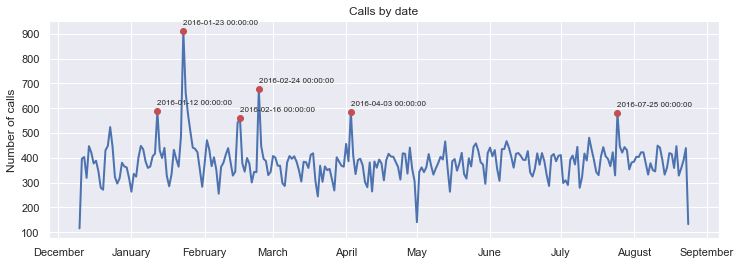

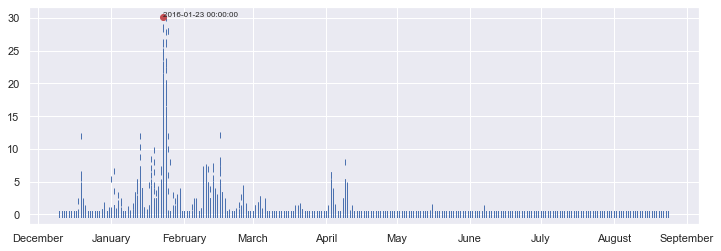

In [25]:
weather_prcp = weather[["date", "snow"]].set_index("date").squeeze()
peakSnow, _ = find_peaks(weather_prcp, height=30.2)

# dates = mpl.dates.date2num(weather_prcp.index)
fig1, ax1 = plt.subplots(figsize=(12, 4))

ax1.plot_date(weather_prcp.index, weather_prcp, '|', linewidth = 1,xdate=True)
ax1.plot_date(weather_prcp.index[peakSnow], weather_prcp[peakSnow], 'ro')

# Add labels to the plot
style = dict(size=6, color='black', bbox=dict(facecolor='gray', alpha=0.5))

myFmt = mdates.DateFormatter('%B')
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(myFmt)

# Add labels to the plot
style = dict(size=6, color='black', bbox=dict(facecolor='gray', alpha=0.5))
# #annotation
for date in range(len(weather_prcp.index[peakSnow])):
    plt.text(weather_prcp.index[peakSnow][date], weather_prcp[peakSnow][date], s= f'{weather_prcp.index[peakSnow][date]}', fontsize=8)
    
ax
fig

We can in the plotted above that between Januray and April there was a lot of snow and also alot of calls.
My guess - traffic:

In [26]:
df1 = df[df.date.map(lambda x: x.month==1 or x.month==2 or x.month==3 )]

# df1.groupby("issue")["lat"].count().sort_values(ascending=False)[:5]
# #code from line 14 

EMS_stats = df.groupby("reason")["issue"].value_counts().loc[["EMS"]]
Traffic_stats = df.groupby("reason")["issue"].value_counts().loc[["Traffic"]]
fire_stats = df.groupby("reason")["issue"].value_counts().loc[["Fire"]]
accidents_1 = EMS_stats.loc["EMS"].loc[["VEHICLE ACCIDENT"]].sum()
accidents_2 = Traffic_stats.loc["Traffic"].sum()
accidents_3 = fire_stats.loc["Fire"].loc[["VEHICLE ACCIDENT"]].sum()
proportion = (accidents_1+accidents_2+accidents_3)/len(df)

print(f"{proportion:.3%} of the cases are vehicle accidents")
print("Top accidents between January-March")
df1.groupby("issue")["lat"].count().sort_values(ascending=False)[:10]

41.479% of the cases are vehicle accidents
Top accidents between January-March


issue
VEHICLE ACCIDENT         7930
DISABLED VEHICLE         3353
RESPIRATORY EMERGENCY    1969
FIRE ALARM               1951
CARDIAC EMERGENCY        1836
VEHICLE ACCIDENT         1779
FALL VICTIM              1749
ROAD OBSTRUCTION         1035
SUBJECT IN PAIN           961
HEAD INJURY               914
Name: lat, dtype: int64